<a href="https://colab.research.google.com/github/TravisJRCain/OKC-Thunder-Data-Analysis/blob/main/OKC_Thunder_Data_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GOAL: Create a model to predict the chance a given shot is rebounded by the
# offensive team (i.e. an offensive rebound)

# a single CSV named 'testing_predictions.csv' with two columns:
# playbyplayorder_id (from testing_data_pbp.csv)
# prediction: your prediction for the percentage chance the shot is offensively rebounded


# Possible solutions = creating a function where inputted data spits out offensive
# rebound chance

# one solution = inserting player_id and obtaining off_reb_pct

In [ ]:
%%capture
import sys

!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
# import various libraries

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import all data sets

import pandas as pd
import csv

player_reb_df = pd.read_csv('/content/player_reb_data.csv')
player_pos_df = pd.read_csv('/content/player_pos_data.csv')
testing_data_pbp = pd.read_csv('/content/testing_data_pbp.csv')
training_data_pbp = pd.read_csv('/content/training_data_pbp.csv')
testing_data_loc = pd.read_csv('/content/testing_data_loc.csv')
training_data_loc = pd.read_csv('/content/training_data_loc.csv')

In [ ]:
# player reb data set

player_reb_df.head()

,Unnamed: 0,player_id,games,minutes,off_rebs,def_rebs,off_rebchances,def_rebchances
0,1,39,50,856.516667,33,222,744,759
1,2,166,54,1680.123333,39,210,1638,1461
2,3,317,70,1962.798333,148,474,1706,1805
3,4,251,214,3987.693333,95,441,3715,3584
4,5,10,187,4956.941667,85,978,4581,4379


In [ ]:
# player pos data set

player_pos_df.head()

,Unnamed: 0,player_id,position,position2
0,1,1,1.0,NaN
1,2,2,2.0,1.0
2,3,3,1.0,NaN
3,4,4,2.0,1.0
4,5,5,5.0,NaN


In [ ]:
# testing data pbp data set

testing_data_pbp.head()

,Unnamed: 0,game_id,playbyplayorder_id,row_type,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,eventdescription,actiondescription,shooter_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5
0,1,5838,1148157,shot,1,3,1,3,0,0,1,0,1,0,0,0,0,0,0,Made Shot,Layup Shot,4,4,162,196,260,192,18,92,212,874,166
1,2,4902,964867,final ft,8,3,8,3,0,1,0,0,0,0,0,0,0,0,0,Free Throw,Free Throw 2 of 2,15,355,61,15,137,410,376,135,928,818,166
2,3,6918,1359847,shot,11,3,11,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Jump Shot,81,81,186,311,228,854,357,55,20,204,166
3,4,1429,281709,shot,28,3,3,28,0,0,1,0,1,0,0,0,0,0,0,Made Shot,Running Layup Shot,290,103,108,112,290,378,357,55,20,204,166
4,5,6007,1181434,shot,7,3,3,7,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Fadeaway Jump Shot,153,49,153,298,878,475,18,214,23,874,166


In [ ]:
testing_data_pbp['actiondescription'].value_counts()

Jump Shot                    144829
Free Throw 2 of 2             37606
Pullup Jump shot              28050
Driving Layup Shot            26108
Layup Shot                    25140
                              ...  
Running Reverse Dunk Shot        28
Running Tip Shot                 21
Jump Bank Hook Shot               8
Reverse Slam Dunk Shot            7
Running Bank Hook Shot            5
Name: actiondescription, Length: 67, dtype: int64

In [ ]:
# curious about the 'secondchance' column in this data set

testing_data_pbp['secondchance'].value_counts()

0    343545
1     40525
2      5499
3       826
4       128
5        23
6         3
7         1
Name: secondchance, dtype: int64

In [ ]:
# training data pbp data set

training_data_pbp.head()

,Unnamed: 0,game_id,playbyplayorder_id,row_type,f.oreb,reboffensive,rebdefensive,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,eventdescription,actiondescription,shooter_player_id,reb_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5
0,1,3380,665919,shot,No,0,1,25,3,25,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Pullup Jump shot,194,357.0,59,194,624,418,326,357,55,20,204,166
1,2,2316,456069,shot,NaN,0,0,12,3,3,12,0,0,1,0,1,0,0,0,0,0,1,Made Shot,Cutting Layup Shot,283,NaN,87,124,283,916,487,20,204,376,818,166
2,3,6244,1227471,shot,Yes,1,0,28,3,3,28,0,0,0,1,1,0,0,0,0,0,1,Missed Shot,Jump Shot,290,112.0,103,108,161,112,290,22,92,212,269,166
3,4,5349,1052145,shot,No,0,1,6,3,6,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Layup Shot,372,92.0,41,180,372,964,374,18,22,92,212,166
4,5,7411,1455880,shot,No,0,1,13,3,3,13,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Jump Shot,93,166.0,91,165,93,229,367,18,22,212,874,166


In [ ]:
# testing data loc data set

testing_data_loc.head()

,Unnamed: 0,game_id,playbyplayorder_id,row_type,AtShot_loc_x_off_player_1,AtShot_loc_y_off_player_1,AtRim_loc_x_off_player_1,AtRim_loc_y_off_player_1,AtShot_loc_x_off_player_2,AtShot_loc_y_off_player_2,AtRim_loc_x_off_player_2,AtRim_loc_y_off_player_2,AtShot_loc_x_off_player_3,AtShot_loc_y_off_player_3,AtRim_loc_x_off_player_3,AtRim_loc_y_off_player_3,AtShot_loc_x_off_player_4,AtShot_loc_y_off_player_4,AtRim_loc_x_off_player_4,AtRim_loc_y_off_player_4,AtShot_loc_x_off_player_5,AtShot_loc_y_off_player_5,AtRim_loc_x_off_player_5,AtRim_loc_y_off_player_5,AtShot_loc_x_def_player_1,AtShot_loc_y_def_player_1,AtRim_loc_x_def_player_1,AtRim_loc_y_def_player_1,AtShot_loc_x_def_player_2,AtShot_loc_y_def_player_2,AtRim_loc_x_def_player_2,AtRim_loc_y_def_player_2,AtShot_loc_x_def_player_3,AtShot_loc_y_def_player_3,AtRim_loc_x_def_player_3,AtRim_loc_y_def_player_3,AtShot_loc_x_def_player_4,AtShot_loc_y_def_player_4,AtRim_loc_x_def_player_4,AtRim_loc_y_def_player_4,AtShot_loc_x_def_player_5,AtShot_loc_y_def_player_5,AtRim_loc_x_def_player_5,AtRim_loc_y_def_player_5
0,1,4,595,shot,-19.027053,19.871164,-19.561299,18.261468,-28.772848,-20.131305,-25.062257,-18.849274,-35.727042,0.056894,-36.683142,0.485297,-21.718015,-0.122900,-21.536141,-1.049679,-42.933800,-2.954257,-42.450831,-7.020800,-30.313182,13.079389,-28.819731,12.686616,-36.366071,-0.889537,-37.833065,0.788378,-40.388325,-15.063114,-37.198845,-17.366327,-40.893383,5.999704,-40.185606,3.857986,-41.937047,0.940924,-41.128611,-0.126855
1,2,4,596,shot,-31.241325,-16.557071,-28.321632,-15.065638,-16.253902,-0.423465,-12.688562,-0.403866,-19.962568,18.050059,-22.438178,21.436732,-22.267783,-17.658709,-16.806480,-15.581163,-43.119577,-7.042437,-36.184143,-4.055952,-27.506331,-13.005224,-30.004851,-10.229823,-19.687610,8.166961,-26.917843,15.506522,-41.568225,-5.037688,-38.935461,-3.489779,-35.476110,-7.463574,-36.617299,-5.663391,-25.744579,2.007568,-26.997568,0.148252
2,3,4,597,shot,-19.010274,-13.595167,-12.321997,-9.573885,-33.948531,12.760393,-26.410282,5.297664,-37.938265,12.372708,-39.921541,9.371487,-39.754267,-15.841310,-33.000484,-22.657571,-11.648523,-0.822028,-7.926558,1.008257,-39.260988,-10.741392,-36.701047,-14.387412,-29.183052,-12.320852,-37.320201,-4.483016,-37.356996,7.594868,-30.802708,6.006223,-25.341379,-1.232503,-28.746937,-1.924971,-37.276387,4.779776,-41.756499,5.591011
3,4,4,598,shot,-33.708835,-13.357808,-29.629455,-16.061489,-40.948591,22.274634,-35.058592,20.020636,-28.173718,-19.808732,-27.313614,-23.975338,-23.689102,18.961400,-19.276782,15.696853,-21.624290,-2.711026,-16.460297,-3.869925,-36.819715,7.634359,-40.679852,4.302618,-26.082251,-16.551544,-27.459762,-18.347463,-28.691778,-0.707390,-34.623914,-1.302901,-35.477993,-6.979465,-36.038071,-9.675009,-27.585973,11.054745,-29.002834,9.131641
4,5,4,599,shot,-14.256493,5.269441,-13.189371,2.904353,-46.556349,4.344373,-42.790092,-2.894734,-33.112281,13.359658,-29.578358,19.549146,-32.849131,-2.990595,-37.449492,-1.893039,-40.149508,-23.188038,-36.643938,-20.558150,-37.705745,-1.683326,-38.195458,-2.167620,-32.035198,11.597627,-26.306290,12.351396,-46.258321,4.739104,-44.305512,-1.282830,-37.705134,-9.482981,-39.735703,-5.733037,-39.595369,5.797657,-34.375548,6.279269


In [ ]:
# training data loc data set

training_data_loc.head()

,Unnamed: 0,game_id,playbyplayorder_id,row_type,AtShot_loc_x_off_player_1,AtShot_loc_y_off_player_1,AtRim_loc_x_off_player_1,AtRim_loc_y_off_player_1,AtShot_loc_x_off_player_2,AtShot_loc_y_off_player_2,AtRim_loc_x_off_player_2,AtRim_loc_y_off_player_2,AtShot_loc_x_off_player_3,AtShot_loc_y_off_player_3,AtRim_loc_x_off_player_3,AtRim_loc_y_off_player_3,AtShot_loc_x_off_player_4,AtShot_loc_y_off_player_4,AtRim_loc_x_off_player_4,AtRim_loc_y_off_player_4,AtShot_loc_x_off_player_5,AtShot_loc_y_off_player_5,AtRim_loc_x_off_player_5,AtRim_loc_y_off_player_5,AtShot_loc_x_def_player_1,AtShot_loc_y_def_player_1,AtRim_loc_x_def_player_1,AtRim_loc_y_def_player_1,AtShot_loc_x_def_player_2,AtShot_loc_y_def_player_2,AtRim_loc_x_def_player_2,AtRim_loc_y_def_player_2,AtShot_loc_x_def_player_3,AtShot_loc_y_def_player_3,AtRim_loc_x_def_player_3,AtRim_loc_y_def_player_3,AtShot_loc_x_def_player_4,AtShot_loc_y_def_player_4,AtRim_loc_x_def_player_4,AtRim_loc_y_def_player_4,AtShot_loc_x_def_player_5,AtShot_loc_y_def_player_5,AtRim_loc_x_def_player_5,AtRim_loc_y_def_player_5
0,1,8,1379,shot,-43.648817,-21.886196,-42.289158,-22.517425,-39.060457,-6.256763,-37.986458,-5.012755,-23.493163,-14.896039,-22.834331,-14.937105,-42.911336,3.473677,-41.387093,2.050828,-29.922922,-20.534299,-29.419936,-20.474042,-28.252522,-9.956282,-27.505773,-9.493411,-38.453253,1.002708,-39.016729,0.902496,-36.584503,-5.131944,-37.699404,-5.352922,-37.297139,0.203133,-36.933941,-0.336016,-42.696037,-9.402359,-41.918629,-8.539802
1,2,8,1380,shot,-41.179048,-23.891722,-37.122629,-23.177840,-40.540140,22.875044,-38.674739,22.950355,-37.842062,-3.251909,-38.104559,-1.419403,-36.377056,6.410832,-35.689158,3.985698,-23.612382,-2.519468,-15.038482,-3.893163,-29.861693,1.438005,-26.958606,-1.154761,-39.367240,-6.758688,-37.581219,-10.576911,-39.434442,6.754536,-39.016553,3.298064,-39.567045,-2.037872,-39.988985,-0.909305,-40.790796,14.652964,-40.390343,13.323796
2,3,8,1381,shot,-44.880723,-23.307184,-44.240890,-21.381771,-43.861148,2.653954,-41.780069,1.215472,-32.409728,24.106612,-32.927992,22.656933,-16.734493,13.318846,-14.364874,11.237947,-21.191924,-12.756171,-19.991742,-12.762639,-34.585501,16.145489,-34.416413,16.877854,-26.718384,6.189453,-28.404883,5.040932,-42.567117,4.996908,-42.475850,3.011978,-41.932962,-7.616737,-41.760967,-4.860211,-28.924595,-7.303918,-30.620121,-8.088317
3,4,8,1382,shot,-36.324736,23.242563,-30.859169,18.254055,-41.560159,-15.662187,-42.533999,-16.142221,-49.117286,-6.748096,-46.129419,-4.639999,-35.471291,9.455880,-34.185306,8.480447,-28.775961,-12.966705,-23.886446,-13.853427,-42.395687,-9.033569,-41.122610,-11.771800,-39.877208,2.474459,-39.879545,5.521357,-35.508664,-7.310620,-38.344859,-3.909418,-40.504097,13.970456,-37.996230,9.926756,-34.313047,-17.530376,-36.845039,-17.290519
4,5,8,1383,shot,-27.609036,-6.286383,-19.092240,-7.244735,-19.579963,-15.127800,-11.755558,-11.769596,-36.987174,8.414099,-35.699724,5.216617,-41.843055,-22.783231,-44.681689,-23.157430,-8.281322,3.069789,-3.759128,6.904515,-39.585786,-19.223505,-37.362024,-27.317024,-17.979623,-2.091171,-17.180221,-0.576425,-28.737417,-11.971262,-33.070691,-8.653539,-41.034914,3.981984,-39.006937,4.605167,-36.231217,-2.679454,-40.551412,-5.541517


In [ ]:
training_data_loc.sample(5)

,Unnamed: 0,game_id,playbyplayorder_id,row_type,AtShot_loc_x_off_player_1,AtShot_loc_y_off_player_1,AtRim_loc_x_off_player_1,AtRim_loc_y_off_player_1,AtShot_loc_x_off_player_2,AtShot_loc_y_off_player_2,AtRim_loc_x_off_player_2,AtRim_loc_y_off_player_2,AtShot_loc_x_off_player_3,AtShot_loc_y_off_player_3,AtRim_loc_x_off_player_3,AtRim_loc_y_off_player_3,AtShot_loc_x_off_player_4,AtShot_loc_y_off_player_4,AtRim_loc_x_off_player_4,AtRim_loc_y_off_player_4,AtShot_loc_x_off_player_5,AtShot_loc_y_off_player_5,AtRim_loc_x_off_player_5,AtRim_loc_y_off_player_5,AtShot_loc_x_def_player_1,AtShot_loc_y_def_player_1,AtRim_loc_x_def_player_1,AtRim_loc_y_def_player_1,AtShot_loc_x_def_player_2,AtShot_loc_y_def_player_2,AtRim_loc_x_def_player_2,AtRim_loc_y_def_player_2,AtShot_loc_x_def_player_3,AtShot_loc_y_def_player_3,AtRim_loc_x_def_player_3,AtRim_loc_y_def_player_3,AtShot_loc_x_def_player_4,AtShot_loc_y_def_player_4,AtRim_loc_x_def_player_4,AtRim_loc_y_def_player_4,AtShot_loc_x_def_player_5,AtShot_loc_y_def_player_5,AtRim_loc_x_def_player_5,AtRim_loc_y_def_player_5
208540,208541,4219,830605,shot,-19.611069,3.576456,-16.509007,7.058304,-42.216044,8.980461,-40.200862,9.047508,-38.633855,21.154858,-39.140162,21.366435,-21.226590,19.559917,-15.403348,16.600932,-24.421334,-6.950829,-35.792609,-3.888359,-26.903049,9.448146,-32.187982,2.681823,-34.228323,12.405346,-36.294635,7.578985,-26.909677,2.937343,-23.903915,0.768953,-20.249373,-4.204004,-18.967505,1.122131,-40.024459,5.836878,-40.884367,5.636963
17453,17454,381,76062,shot,-16.253557,7.185556,-13.286775,5.477075,-41.042606,1.516393,-42.259978,6.004073,-9.203984,-16.303142,-8.304633,-16.330392,-16.389195,0.670186,-14.569114,0.269593,-36.228924,1.867601,-37.967851,0.454474,-36.805009,6.179418,-36.877784,2.665596,-23.394302,1.910784,-23.427656,2.653338,-38.480370,-1.186226,-41.046674,-0.247332,-41.160048,1.038654,-42.861296,1.981810,-24.077557,-10.187505,-26.994972,-10.287673
149117,149118,3056,602111,final ft,-32.572209,12.875819,NaN,NaN,-9.851075,9.029715,NaN,NaN,-35.883390,-0.839995,NaN,NaN,-14.276274,-9.557879,NaN,NaN,-18.201093,15.880399,NaN,NaN,-29.658011,0.224517,NaN,NaN,-36.973546,-1.800160,NaN,NaN,-29.817689,5.930044,NaN,NaN,-23.342279,-5.171673,NaN,NaN,-39.918411,8.062201,NaN,NaN
307327,307328,6263,1231305,shot,15.210517,-11.989161,10.864636,-11.875326,-39.117491,2.661716,-45.143487,-0.018035,-30.870600,3.904208,-37.288580,1.083453,49.597596,5.429009,50.700683,5.633298,-26.959728,-0.805757,-29.222514,-0.347938,-37.743690,-0.864860,-39.114496,-0.257129,-37.659512,3.417534,-39.788552,3.591964,-30.451160,-1.634319,-34.315121,-1.845362,-30.180074,9.567205,-34.564203,7.967974,5.669911,5.050495,-3.087152,4.193476
232271,232272,4712,927441,shot,-31.052402,18.211012,-29.701372,17.422591,-34.088032,-21.899795,-30.142065,-21.101146,-40.917872,-0.993371,-44.190944,-1.902699,-28.973598,-13.890069,-26.025212,-11.573982,-44.968429,-12.047109,-44.412785,-8.369687,-36.293158,-8.440949,-36.400372,-6.027720,-37.385755,-5.968891,-37.317910,-5.414944,-39.447581,-13.049922,-40.495522,-12.303096,-35.307328,-0.144287,-35.728017,-0.030743,-38.509451,5.470634,-41.035748,2.304198


In [ ]:
# some initial data cleaning
# drop first column in all data sets

player_pos_df = player_pos_df.drop(['Unnamed: 0'], axis=1)
player_reb_df = player_reb_df.drop(['Unnamed: 0'], axis=1)
testing_data_loc = testing_data_loc.drop(['Unnamed: 0'], axis=1)
testing_data_pbp = testing_data_pbp.drop(['Unnamed: 0'], axis=1)
training_data_loc = training_data_loc.drop(['Unnamed: 0'], axis=1)
training_data_pbp = training_data_pbp.drop(['Unnamed: 0'], axis=1)

In [ ]:
# make sure the dropping of the first column is confirmed

player_pos_df.head()

,player_id,position,position2
0,1,1.0,NaN
1,2,2.0,1.0
2,3,1.0,NaN
3,4,2.0,1.0
4,5,5.0,NaN


In [ ]:
player_pos_df['position'].value_counts()

2.0    325
4.0    317
1.0    278
3.0    236
5.0    218
Name: position, dtype: int64

In [ ]:
player_pos_df['position2'].value_counts()

2.0    124
3.0    123
4.0    121
1.0     73
5.0     61
Name: position2, dtype: int64

In [ ]:
# closer look at data, potentially split up data from total amount of games played

training_data_loc['game_id'].describe()

count    372181.000000
mean       3784.528899
std        2225.381278
min           8.000000
25%        1851.000000
50%        3751.000000
75%        5729.000000
max        7689.000000
Name: game_id, dtype: float64

In [ ]:
# half of the games in new data set

new_training_data_loc = training_data_loc[training_data_loc['game_id'] >= 3800]
new_training_data_loc.shape

(184731, 43)

In [ ]:
player_reb_df.sample(5)

,player_id,games,minutes,off_rebs,def_rebs,off_rebchances,def_rebchances
656,492,11,81.400000,5,14,81,82
416,78,225,7036.140000,180,623,6669,6437
468,163,56,1075.051667,28,129,1054,906
686,486,148,3469.730000,41,331,3122,3201
509,219,20,98.260000,5,11,90,83


In [ ]:
player_reb_df['games'].describe()

count    1007.000000
mean       81.883813
std        77.274956
min         1.000000
25%        13.000000
50%        54.000000
75%       141.000000
max       285.000000
Name: games, dtype: float64

In [ ]:
# create new columns for off reb and def reb pct along with total rebs

player_reb_df['off_reb_pct'] = player_reb_df.off_rebs / player_reb_df.off_rebchances
player_reb_df['def_reb_pct'] = player_reb_df.def_rebs / player_reb_df.def_rebchances
player_reb_df['total_rebs'] = player_reb_df.off_rebs + player_reb_df.def_rebs

In [ ]:
player_reb_df.sample(5)

,player_id,games,minutes,off_rebs,def_rebs,off_rebchances,def_rebchances,off_reb_pct,def_reb_pct,total_rebs
877,941,2,2.278333,0,0,1,3,0.000000,0.000000,0
8,46,58,854.133333,22,73,683,740,0.032211,0.098649,95
181,8,153,4236.673333,255,504,3898,3706,0.065418,0.135996,759
63,145,201,5848.433333,675,1585,5348,5374,0.126215,0.294939,2260
855,695,40,699.315000,13,70,665,656,0.019549,0.106707,83


In [ ]:
# creating function to insert player_id and obtaining off_reb_pct

def player_off_reb_pct():
  inputid = input('Please input Player ID: ')
  try:
    return player_reb_df.loc[int(inputid), 'off_reb_pct']
  except:
    return 'No Player ID found'

# player_reb_df.set_index('player_id', inplace=True)

In [ ]:
# example of function running properly

player_off_reb_pct()

Please input Player ID: 278


0.12405446293494705

In [ ]:
# merge data sets together by player_id

player_pos_reb_df = player_pos_df.merge(player_reb_df, how='inner', on='player_id')

In [ ]:
# make sure data set added positions correctly

player_pos_reb_df.head()

,player_id,position,position2,games,minutes,off_rebs,def_rebs,off_rebchances,def_rebchances,off_reb_pct,def_reb_pct,total_rebs
0,1,1.0,NaN,26,224.023333,3,14,221,196,0.013575,0.071429,17
1,2,2.0,1.0,31,456.723333,3,40,410,398,0.007317,0.100503,43
2,3,1.0,NaN,179,5270.776667,196,599,4964,4783,0.039484,0.125235,795
3,4,2.0,1.0,141,3864.670000,94,501,3460,3538,0.027168,0.141605,595
4,5,5.0,NaN,209,6455.763333,511,1638,6047,5745,0.084505,0.285117,2149


In [ ]:
# fill NaN values

player_pos_reb_df = player_pos_reb_df.fillna(0)

In [ ]:
player_pos_reb_df.head()

,player_id,position,position2,games,minutes,off_rebs,def_rebs,off_rebchances,def_rebchances,off_reb_pct,def_reb_pct,total_rebs
0,1,1.0,0.0,26,224.023333,3,14,221,196,0.013575,0.071429,17
1,2,2.0,1.0,31,456.723333,3,40,410,398,0.007317,0.100503,43
2,3,1.0,0.0,179,5270.776667,196,599,4964,4783,0.039484,0.125235,795
3,4,2.0,1.0,141,3864.670000,94,501,3460,3538,0.027168,0.141605,595
4,5,5.0,0.0,209,6455.763333,511,1638,6047,5745,0.084505,0.285117,2149


In [ ]:
# train/test/val split information to consider for creating model:
# - can split data up by games or minutes
# - consider location of player, position

player_pos_reb_df['minutes'].describe()

count     1007.000000
mean      1865.117931
std       2205.757235
min          0.266667
25%        139.780833
50%        854.133333
75%       2980.889167
max      10494.101667
Name: minutes, dtype: float64

In [ ]:
from statistics import mode

mode(player_pos_reb_df['minutes'])

12.0

In [ ]:
player_pos_reb_df['games'].describe()

count    1007.000000
mean       81.883813
std        77.274956
min         1.000000
25%        13.000000
50%        54.000000
75%       141.000000
max       285.000000
Name: games, dtype: float64

In [ ]:
# train/test/val split on data w/ minutes

train = player_pos_reb_df[player_pos_reb_df['minutes'] <= 1500]
val = player_pos_reb_df[player_pos_reb_df['minutes'] == 12] # most common amount (most likely because quarters are 12 min each)
test = player_pos_reb_df[player_pos_reb_df['minutes'] >= 1500]

In [ ]:
train.shape, val.shape, test.shape

((605, 12), (3, 12), (402, 12))

In [ ]:
features = ['off_rebs', 'off_rebchances', 'total_rebs', 'position', 'position2']
target = 'off_reb_pct'

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]

In [ ]:
# Fit Linear Regression Model
# Baseline
lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(),
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 -0.7061700470305348


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
from sklearn.linear_model import LinearRegression
# Instantiate model class
model = LinearRegression()

In [ ]:
# Random Forest Regression Model
# Baseline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.9953860049278881


In [ ]:
# Instantiate one-hot encoder
encoder = ce.OneHotEncoder()

# Fit and transform on train/test sets
X_train1 = encoder.fit_transform(X_train)
X_test1 = encoder.transform(X_test)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# Instantiate model class
model = LinearRegression()
# Fit the model
model.fit(X_train1, y_train)
# Apply the model to new data
y_pred1 = model.predict(X_train1)
y_pred2 = model.predict(X_test1)

In [ ]:
# xgboost

from xgboost import XGBRegressor

# Instantiate and fit one-hot encoder
encoder = ce.OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.fit_transform(X_test)

# Instantiate XGBRegressor and parameter tuning
model = XGBRegressor(
    n_estimators = 200,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)
# Instantiate eval_set
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

# Fit model to the eval_set
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='mae', 
          early_stopping_rounds=1000)

[21:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.228654	validation_1-mae:0.227485
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 1000 rounds.
[1]	validation_0-mae:0.115589	validation_1-mae:0.11643
[2]	validation_0-mae:0.059351	validation_1-mae:0.079979
[3]	validation_0-mae:0.031293	validation_1-mae:0.061175
[4]	validation_0-mae:0.017123	validation_1-mae:0.051327
[5]	validation_0-mae:0.009823	validation_1-mae:0.046621
[6]	validation_0-mae:0.00629	validation_1-mae:0.044176
[7]	validation_0-mae:0.004539	validation_1-mae:0.043465
[8]	validation_0-mae:0.003584	validation_1-mae:0.041631
[9]	validation_0-mae:0.002871	validation_1-mae:0.041291
[10]	validation_0-mae:0.002448	validation_1-mae:0.040719
[11]	validation_0-mae:0.002162	validation_1-mae:0.04082


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[12]	validation_0-mae:0.001981	validation_1-mae:0.040601
[13]	validation_0-mae:0.001841	validation_1-mae:0.040555
[14]	validation_0-mae:0.001672	validation_1-mae:0.039978
[15]	validation_0-mae:0.001544	validation_1-mae:0.039935
[16]	validation_0-mae:0.001404	validation_1-mae:0.039921
[17]	validation_0-mae:0.001244	validation_1-mae:0.039691
[18]	validation_0-mae:0.001153	validation_1-mae:0.039513
[19]	validation_0-mae:0.001068	validation_1-mae:0.039535
[20]	validation_0-mae:0.000987	validation_1-mae:0.03954
[21]	validation_0-mae:0.000952	validation_1-mae:0.039347
[22]	validation_0-mae:0.000877	validation_1-mae:0.039507
[23]	validation_0-mae:0.000851	validation_1-mae:0.039506
[24]	validation_0-mae:0.000783	validation_1-mae:0.039572
[25]	validation_0-mae:0.000769	validation_1-mae:0.039646
[26]	validation_0-mae:0.000769	validation_1-mae:0.039647
[27]	validation_0-mae:0.000769	validation_1-mae:0.039648
[28]	validation_0-mae:0.000769	validation_1-mae:0.039648
[29]	validation_0-mae:0.000769	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Calculate r2 for the train and test data
y_pred1 = model.predict(X_train_encoded)
y_pred2 = model.predict(X_test_encoded)
r2 = r2_score(train[target], y_pred1)
print(f'The R2 of the training data is {r2}')
r2 = r2_score(test[target], y_pred2)
print(f'The R2 of the test data is {r2}')

The R2 of the training data is 0.99950454530313
The R2 of the test data is -0.7878929615931671


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
# Instantiate permuter for XGBRegressor
permuter = PermutationImportance(
    model,
    scoring='r2',
    n_iter=5,
    random_state=42
)
# Fit permuter to data from our model
permuter.fit(X_train_encoded, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.5,
                                             max_delta_step=0, max_depth=7,
                                             min_child_weight=1, missing=None,
                                             n_estimators=200, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                      

In [ ]:
# Pull out top features and their importance
feature_names = X_train_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

position2         0.000808
total_rebs        0.008479
position          0.032474
off_rebchances    5.163965
off_rebs          5.319583
dtype: float64

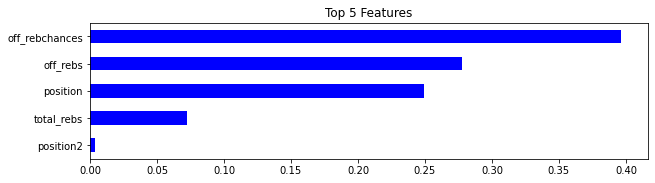

In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} Features')
importances.sort_values()[-n:].plot.barh(color='blue');

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


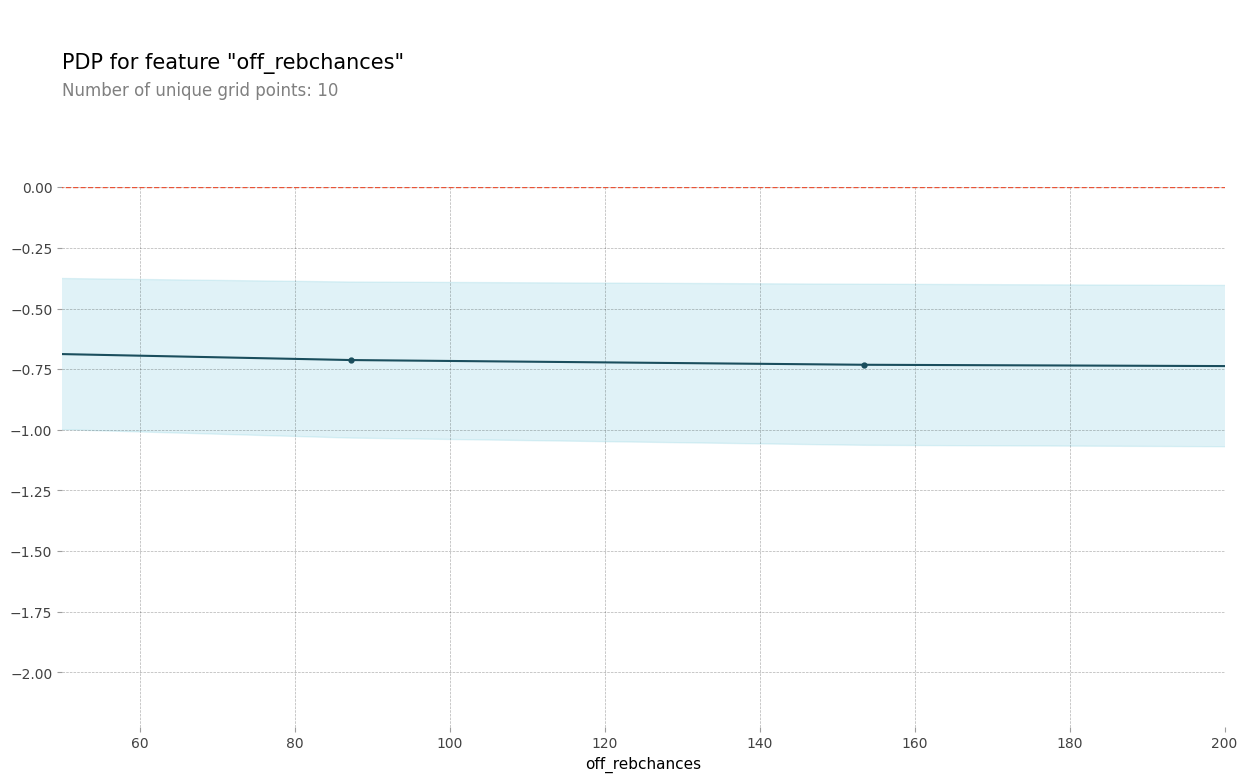

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Designate feature to analyze
feature = 'off_rebchances'

# Instantiate isolated conditional plot
isolated = pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=feature
)
# Visualize pdp plot
pdp_plot(isolated, feature_name=feature)
plt.xlim((50, 200));

(<Figure size 1500x950 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ffae5e5cba8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ffae5e45c50>})

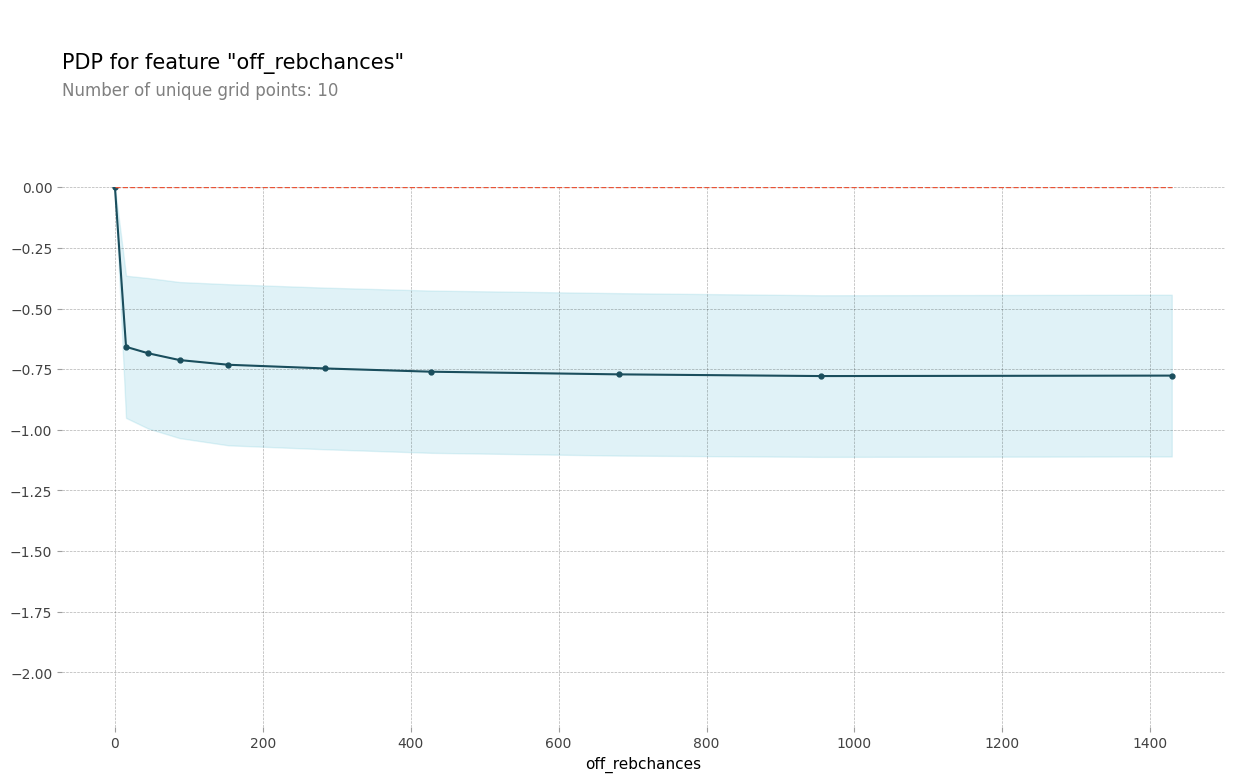

In [ ]:
pdp_plot(isolated, feature_name=feature)

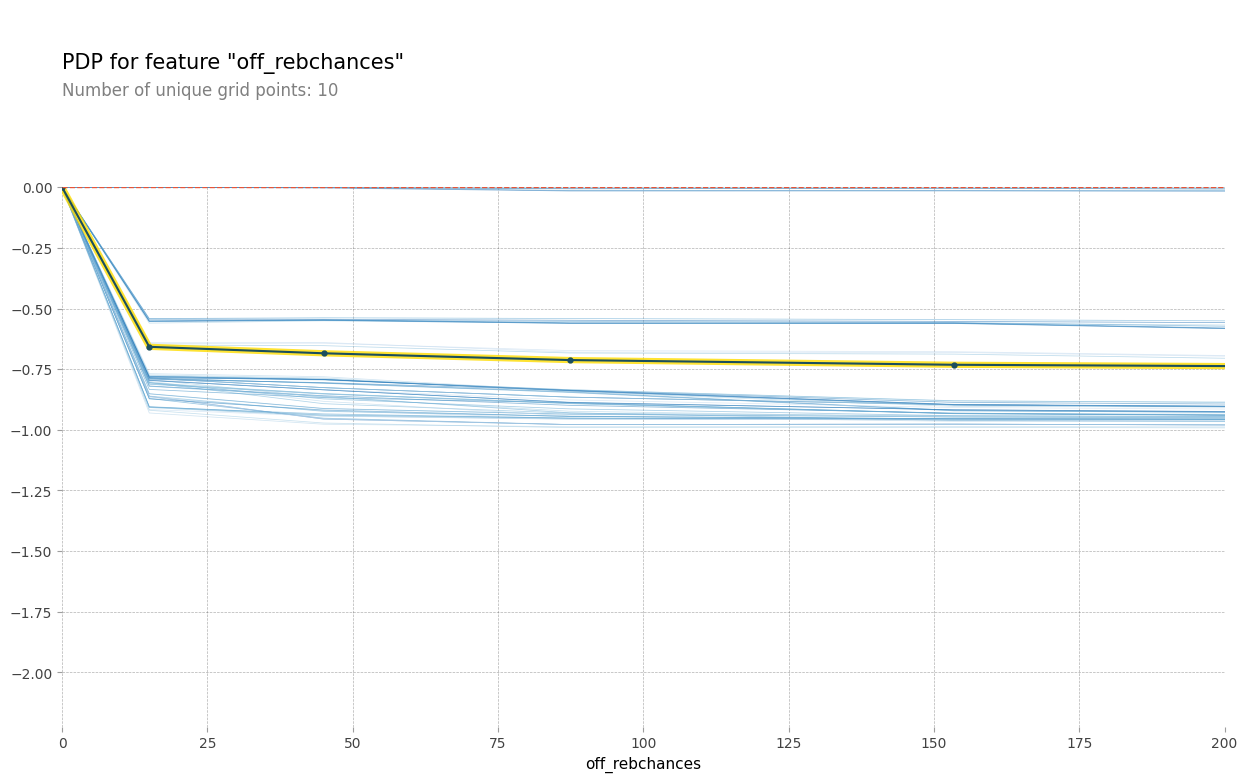

In [ ]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1)

plt.xlim(0,200);

In [ ]:
import shap
# Instantiate individual prediction
row = X_train_encoded.iloc[[0]]

# Instantiate TreeExplainer
explainer = shap.TreeExplainer(model)

# Pull shap values for individual observation
shap_values = explainer.shap_values(row)

# Visualize feature importance on individual prediction
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [ ]:
# Predicting across X_train_encoded 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_encoded)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=X_train
)

In [ ]:
# from the ML algorithms above, off_rebchances, off_rebs clearest have the highest
# factor in deciding when an offensive rebound is obtained

# so, from there, we can denote that the chances of obtaining an offensive rebound
# outweigh all other factors

# we then can take the next data set and use location to create a model in determining

In [ ]:
# making testing_predictions.csv

# first column = playbyplayorder_id (from testing_data_pbp.csv)
# second column = prediction for the perctange chance the shot is offensively rebounded

# must add player_id to merge together then drop player_id

tp_pbpo = testing_data_pbp.filter(['playbyplayorder_id'], axis=1)
prediction_off_reb = player_pos_reb_df.filter(['off_reb_pct'], axis=1)

In [ ]:
tp_pbpo.head()

,playbyplayorder_id
0,1148157
1,964867
2,1359847
3,281709
4,1181434


In [ ]:
prediction_off_reb.head()

,off_reb_pct
0,0.013575
1,0.007317
2,0.039484
3,0.027168
4,0.084505


In [ ]:
# merging the above data sets together

testing_predictions = pd.concat([tp_pbpo, prediction_off_reb], axis=1, sort=False)

In [ ]:
testing_predictions.sample(10)

,playbyplayorder_id,off_reb_pct
35972,115822,NaN
332307,992522,NaN
13269,879683,NaN
50778,1310867,NaN
353193,882224,NaN
50454,809089,NaN
161573,927636,NaN
245855,379526,NaN
17582,702001,NaN
314619,1401264,NaN


In [ ]:
testing_predictions['off_reb_pct'].describe()

count    1007.000000
mean        0.048969
std         0.053422
min         0.000000
25%         0.017928
50%         0.032787
75%         0.072205
max         1.000000
Name: off_reb_pct, dtype: float64

In [ ]:
# given the observed data above, there is roughly a 5% chance of an offensive rebound on any given play

In [ ]:
testing_predictions.to_csv(r'C:\Users\Travis Cain\Desktop\testing_predictions.csv', index=False, header=True)

In [ ]:
# dataframe to csv

compression_opts = dict(method='zip',
                        archive_name='testing_predictions.csv')  
testing_predictions.to_csv('testing_predictions.zip', index=False,
          compression=compression_opts)

In [ ]:
################################################################################

In [ ]:
# more predictive and accurate modeling

# we already have our train and test data sets

# make f.oreb the target from training_data_pbp data set because this is what we want to find out

training_data_pbp['f.oreb'].value_counts()

No     136189
Yes     48158
Name: f.oreb, dtype: int64

In [ ]:
# make 'No' = 0 and 'Yes' = 1 for predicting modeling purposes

training_data_pbp['f.oreb'] = training_data_pbp['f.oreb'].replace({'No': 0})
training_data_pbp['f.oreb'] = training_data_pbp['f.oreb'].replace({'Yes': 1})

In [ ]:
# fill NaN from 'f.oreb' column because NaN represents no rebound opportunity

training_data_pbp['f.oreb'] = training_data_pbp['f.oreb'].fillna(0)

In [ ]:
training_data_pbp['f.oreb'].value_counts()

0.0    324023
1.0     48158
Name: f.oreb, dtype: int64

In [ ]:
# this will denote whether a team got an offensive rebound or not
# now, time to set up training the model

In [ ]:
testing_data_pbp.head()

,game_id,playbyplayorder_id,row_type,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,eventdescription,actiondescription,shooter_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5
0,5838,1148157,shot,1,3,1,3,0,0,1,0,1,0,0,0,0,0,0,Made Shot,Layup Shot,4,4,162,196,260,192,18,92,212,874,166
1,4902,964867,final ft,8,3,8,3,0,1,0,0,0,0,0,0,0,0,0,Free Throw,Free Throw 2 of 2,15,355,61,15,137,410,376,135,928,818,166
2,6918,1359847,shot,11,3,11,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Jump Shot,81,81,186,311,228,854,357,55,20,204,166
3,1429,281709,shot,28,3,3,28,0,0,1,0,1,0,0,0,0,0,0,Made Shot,Running Layup Shot,290,103,108,112,290,378,357,55,20,204,166
4,6007,1181434,shot,7,3,3,7,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Fadeaway Jump Shot,153,49,153,298,878,475,18,214,23,874,166


In [ ]:
test_testing_data_pbp = testing_data_pbp.drop(['row_type', 'eventdescription', 
                                               'actiondescription'], axis=1)

In [ ]:
train_training_data_pbp = training_data_pbp.drop(['row_type', 'eventdescription', 
                                               'actiondescription'], axis=1)

In [ ]:
train_training_data_pbp.head()

,game_id,playbyplayorder_id,f.oreb,reboffensive,rebdefensive,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,shooter_player_id,reb_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5
0,3380,665919,0.0,0,1,25,3,25,3,0,0,0,1,1,0,0,0,0,0,0,194,357.0,59,194,624,418,326,357,55,20,204,166
1,2316,456069,NaN,0,0,12,3,3,12,0,0,1,0,1,0,0,0,0,0,1,283,NaN,87,124,283,916,487,20,204,376,818,166
2,6244,1227471,1.0,1,0,28,3,3,28,0,0,0,1,1,0,0,0,0,0,1,290,112.0,103,108,161,112,290,22,92,212,269,166
3,5349,1052145,0.0,0,1,6,3,6,3,0,0,0,1,1,0,0,0,0,0,0,372,92.0,41,180,372,964,374,18,22,92,212,166
4,7411,1455880,0.0,0,1,13,3,3,13,0,0,0,1,1,0,0,0,0,0,0,93,166.0,91,165,93,229,367,18,22,212,874,166


In [ ]:
columns = test_testing_data_pbp.columns.tolist()

In [ ]:
target = 'f.oreb'

train = train_training_data_pbp

test = test_testing_data_pbp

linear_model = LinearRegression()

linear_model.fit(train[columns], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
train.shape, test.shape

((372181, 32), (390550, 28))

In [ ]:
# predictions for test set

linear_predictions = linear_model.predict(test[columns])
print('Chances an offensive rebound is obtained: ', linear_predictions)

# linear_mse = mean_squared_error(linear_predictions, test[target])
# print('Computed error: ', linear_mse)

Chances an offensive rebound is obtained:  [-0.00108405  0.1062365   0.29294138 ... -0.00267198  0.21367845
 -0.0019927 ]


In [ ]:
linear_predictions

array([-0.00108405,  0.1062365 ,  0.29294138, ..., -0.00267198,
        0.21367845, -0.0019927 ])

In [ ]:
linear_pred_df = pd.DataFrame(data=linear_predictions)
linear_pred_df 

,0
0,-0.001084
1,0.106237
2,0.292941
3,-0.010415
4,0.295667
...,...
390545,-0.002604
390546,-0.002738
390547,-0.002672
390548,0.213678


In [ ]:
# create proper testing_predictions.csv

testing_predictions = pd.concat([tp_pbpo, linear_pred_df ], axis=1, sort=False)

In [ ]:
testing_predictions

,playbyplayorder_id,0
0,1148157,-0.001084
1,964867,0.106237
2,1359847,0.292941
3,281709,-0.010415
4,1181434,0.295667
...,...,...
390545,1048274,-0.002604
390546,1048280,-0.002738
390547,1048277,-0.002672
390548,1048286,0.213678


In [ ]:
testing_predictions = testing_predictions.rename(columns={'OReb Predction %':'OReb Prediction %'})

In [ ]:
testing_predictions.head()

,playbyplayorder_id,OReb Prediction %
0,1148157,-0.001084
1,964867,0.106237
2,1359847,0.292941
3,281709,-0.010415
4,1181434,0.295667


In [ ]:
testing_predictions.to_csv('testing_predictions.csv')

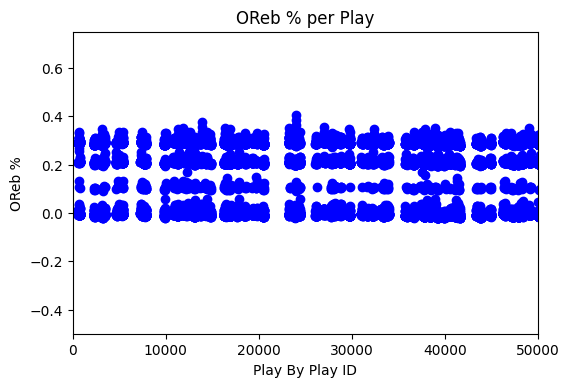

In [ ]:
# graph above results

plt.scatter(testing_predictions['playbyplayorder_id'], testing_predictions['OReb Prediction %'], color='b')
plt.title('OReb % per Play')
plt.xlim([0,50000])
plt.ylim([-0.5,0.75])
plt.xlabel('Play By Play ID')
plt.ylabel('OReb %')
# plt.plot([-5000,90000], [-7000,25000], color = 'black', linewidth = 2)
plt.show();

In [ ]:
# difficult to properly graph results because there are so many play by play IDs

In [ ]:
# trying a third method

# join training_data_pbp with training_data_loc via playbyplayorder_id
# do the same with testing_data_pbp and testing_data_loc

# after that, there will be some data cleaning to make sure all values are numerical
# from there, we can then run another linear regression model and base our outcomes on player location

In [ ]:
# merge data sets together

train_data = training_data_pbp.merge(training_data_loc, how='outer', on='playbyplayorder_id')

In [ ]:
train_data.head()

,game_id_x,playbyplayorder_id,row_type_x,f.oreb,reboffensive,rebdefensive,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,eventdescription,actiondescription,shooter_player_id,reb_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5,game_id_y,row_type_y,AtShot_loc_x_off_player_1,AtShot_loc_y_off_player_1,AtRim_loc_x_off_player_1,AtRim_loc_y_off_player_1,AtShot_loc_x_off_player_2,AtShot_loc_y_off_player_2,AtRim_loc_x_off_player_2,AtRim_loc_y_off_player_2,AtShot_loc_x_off_player_3,AtShot_loc_y_off_player_3,AtRim_loc_x_off_player_3,AtRim_loc_y_off_player_3,AtShot_loc_x_off_player_4,AtShot_loc_y_off_player_4,AtRim_loc_x_off_player_4,AtRim_loc_y_off_player_4,AtShot_loc_x_off_player_5,AtShot_loc_y_off_player_5,AtRim_loc_x_off_player_5,AtRim_loc_y_off_player_5,AtShot_loc_x_def_player_1,AtShot_loc_y_def_player_1,AtRim_loc_x_def_player_1,AtRim_loc_y_def_player_1,AtShot_loc_x_def_player_2,AtShot_loc_y_def_player_2,AtRim_loc_x_def_player_2,AtRim_loc_y_def_player_2,AtShot_loc_x_def_player_3,AtShot_loc_y_def_player_3,AtRim_loc_x_def_player_3,AtRim_loc_y_def_player_3,AtShot_loc_x_def_player_4,AtShot_loc_y_def_player_4,AtRim_loc_x_def_player_4,AtRim_loc_y_def_player_4,AtShot_loc_x_def_player_5,AtShot_loc_y_def_player_5,AtRim_loc_x_def_player_5,AtRim_loc_y_def_player_5
0,3380,665919,shot,0.0,0,1,25,3,25,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Pullup Jump shot,194,357.0,59,194,624,418,326,357,55,20,204,166,3380,shot,-17.384656,12.394683,-17.283457,9.327809,-24.131233,-14.297083,-23.672992,-15.688668,-25.568915,-20.335072,-18.239323,-16.566493,-42.046098,-23.076345,-39.496884,-20.102959,-38.624121,-11.832041,-38.371092,-12.151998,-28.949301,6.744170,-34.039448,4.047393,-25.069328,-11.807806,-25.937232,-9.538451,-38.307357,-7.184459,-39.803211,-8.709652,-31.071664,-9.670843,-26.611135,-15.622551,-34.792343,-13.334990,-33.247587,-7.631263
1,2316,456069,shot,0.0,0,0,12,3,3,12,0,0,1,0,1,0,0,0,0,0,1,Made Shot,Cutting Layup Shot,283,NaN,87,124,283,916,487,20,204,376,818,166,2316,shot,-34.220032,18.668318,-36.089431,15.656447,-29.101474,-15.555530,-28.973241,-16.432213,-40.447596,-1.161477,-43.797802,-1.706129,-8.435779,4.863028,-10.323423,5.426221,-16.921423,4.022199,-18.311896,6.762047,-33.172158,12.607892,-35.157522,10.775418,-34.723853,-6.522151,-36.073663,-4.502594,-33.147679,-10.923129,-32.523821,-10.419638,-36.907692,-1.053055,-40.607096,-1.978516,-4.731572,-2.828309,-7.543935,-0.956155
2,6244,1227471,shot,1.0,1,0,28,3,3,28,0,0,0,1,1,0,0,0,0,0,1,Missed Shot,Jump Shot,290,112.0,103,108,161,112,290,22,92,212,269,166,6244,shot,-37.335704,5.277169,-39.375445,1.608147,-19.765496,1.662329,-32.065151,-0.979400,-19.282656,14.654477,-21.244830,11.090646,-43.492994,-20.162945,-41.251306,-6.034425,-27.361946,-8.031046,-26.930131,-9.739302,-37.549522,-2.129876,-39.161149,0.789798,-29.295700,-1.096915,-34.048702,0.438336,-32.307339,9.602375,-37.106188,7.679048,-28.380909,-6.230190,-28.342733,-12.978960,-34.324679,-12.184792,-36.707621,-7.829441
3,5349,1052145,shot,0.0,0,1,6,3,6,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Layup Shot,372,92.0,41,180,372,964,374,18,22,92,212,166,5349,shot,-22.358678,-0.581120,-21.426839,-1.317855,-27.440522,19.074634,-26.773268,18.578461,-41.042037,-2.229426,-41.371069,-1.794054,-18.940154,-15.329346,-19.583323,-15.840671,-38.984364,4.339363,-39.153310,3.129489,-26.977272,2.392128,-27.040645,2.630367,-28.903059,-9.509659,-30.322156,-9.080836,-37.881921,-0.127257,-39.816112,1.075070,-41.040309,-1.819955,-41.829363,-0.947178,-34.645235,11.603169,-35.751400,10.726267
4,7411,1455880,shot,0.0,0,1,13,3,3,13,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Jump Shot,93,166.0,91,165,93,229,367,18,22,212,874,166,7411,shot,-32.089101,-8.585651,-40.213617,0.421188,-20.882931,17.260021,

In [ ]:
# do the same merge with testing_data_pbp and testing_data_loc

test_data = testing_data_pbp.merge(testing_data_loc, how='outer', on='playbyplayorder_id')

In [ ]:
test_data.head()

,game_id_x,playbyplayorder_id,row_type_x,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,eventdescription,actiondescription,shooter_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5,game_id_y,row_type_y,AtShot_loc_x_off_player_1,AtShot_loc_y_off_player_1,AtRim_loc_x_off_player_1,AtRim_loc_y_off_player_1,AtShot_loc_x_off_player_2,AtShot_loc_y_off_player_2,AtRim_loc_x_off_player_2,AtRim_loc_y_off_player_2,AtShot_loc_x_off_player_3,AtShot_loc_y_off_player_3,AtRim_loc_x_off_player_3,AtRim_loc_y_off_player_3,AtShot_loc_x_off_player_4,AtShot_loc_y_off_player_4,AtRim_loc_x_off_player_4,AtRim_loc_y_off_player_4,AtShot_loc_x_off_player_5,AtShot_loc_y_off_player_5,AtRim_loc_x_off_player_5,AtRim_loc_y_off_player_5,AtShot_loc_x_def_player_1,AtShot_loc_y_def_player_1,AtRim_loc_x_def_player_1,AtRim_loc_y_def_player_1,AtShot_loc_x_def_player_2,AtShot_loc_y_def_player_2,AtRim_loc_x_def_player_2,AtRim_loc_y_def_player_2,AtShot_loc_x_def_player_3,AtShot_loc_y_def_player_3,AtRim_loc_x_def_player_3,AtRim_loc_y_def_player_3,AtShot_loc_x_def_player_4,AtShot_loc_y_def_player_4,AtRim_loc_x_def_player_4,AtRim_loc_y_def_player_4,AtShot_loc_x_def_player_5,AtShot_loc_y_def_player_5,AtRim_loc_x_def_player_5,AtRim_loc_y_def_player_5
0,5838,1148157,shot,1,3,1,3,0,0,1,0,1,0,0,0,0,0,0,Made Shot,Layup Shot,4,4,162,196,260,192,18,92,212,874,166,5838,shot,-40.700036,-1.041135,-42.793211,-1.360212,-30.426168,1.938878,-35.536551,0.302542,-7.374217,-13.194604,-8.758793,-11.443400,-42.780708,-3.003407,-42.736977,-2.925309,-12.129929,12.829824,-14.819710,12.502557,-25.051026,-7.993261,-27.008216,-7.832278,-16.905029,-2.676467,-21.487846,-1.914835,-34.961404,3.714766,-36.878749,2.680759,-41.757861,2.991644,-44.129938,3.194080,-37.731367,-1.639577,-39.011371,-0.852890
1,4902,964867,final ft,8,3,8,3,0,1,0,0,0,0,0,0,0,0,0,Free Throw,Free Throw 2 of 2,15,355,61,15,137,410,376,135,928,818,166,4902,final ft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6918,1359847,shot,11,3,11,3,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Jump Shot,81,81,186,311,228,854,357,55,20,204,166,6918,shot,-43.120729,16.137786,-40.582997,16.371511,-37.937843,-23.477220,-33.100305,-22.048324,-21.019337,-10.285614,-30.950773,-5.652436,-43.616673,-10.984127,-44.805592,-7.067207,-12.720099,3.606094,-10.455597,2.820157,-28.834391,-2.984606,-33.004448,-2.035952,-25.437105,5.021600,-26.693142,8.007401,-39.556475,-13.714048,-38.516950,-11.168972,-41.163969,9.194310,-41.410059,11.241852,-40.045804,-5.085559,-41.101181,-6.267949
3,1429,281709,shot,28,3,3,28,0,0,1,0,1,0,0,0,0,0,0,Made Shot,Running Layup Shot,290,103,108,112,290,378,357,55,20,204,166,1429,shot,-16.915903,0.533566,-21.136590,-1.686715,31.860668,11.927922,31.217742,11.168923,-27.094979,5.345874,-29.916920,2.243129,-40.346592,1.730480,-44.259830,1.395588,37.713186,-6.834192,37.757712,-6.209914,-35.163158,2.373233,-37.315459,3.786191,23.678198,18.722937,22.468822,19.676206,12.698794,-11.287243,9.755953,-11.753311,12.906682,11.131408,10.458029,9.113076,24.833774,-5.532949,23.542835,-7.571050
4,6007,1181434,shot,7,3,3,7,0,0,0,1,1,0,0,0,0,0,0,Missed Shot,Fadeaway Jump Shot,153,49,153,298,878,475,18,214,23,874,166,6007,shot,-36.610314,23.486821,-27.576427,19.883047,-39.307083,-12.756915,-39.496936,-21.767944,-38.215718,7.962992,-40.244227,5.117356,-16.082750,-7.098926,-25.690463,-5.375425,-38.078963,-0.583015,-42.284212,3.177397,-35.060878,-4.231422,-38.840537,-5.965653,-39.541107,-0.362869,-40.955077,-3.556601,-37.187518,-8.859183,-38.339847,-19.392559,-38.670049,8.444717,-39.077093,4.966785,-38.637160,1.757705,-38.902638,1.904237


In [ ]:
# now, data cleaning, dropping non-numeric columns

# filling NaN values

final_train_data = train_data.drop(['row_type_x', 'row_type_y', 'eventdescription', 
                                               'actiondescription'], axis=1)

In [ ]:
final_train_data.fillna(0)

,game_id_x,playbyplayorder_id,f.oreb,reboffensive,rebdefensive,off_team_id,def_team_id,home_team_id,away_team_id,ftmade,ftmissed,fg2made,fg2missed,fg2attempted,fg3made,fg3missed,fg3attempted,secondchance,andone,inbonus,shooter_player_id,reb_player_id,playerid_off_player_1,playerid_off_player_2,playerid_off_player_3,playerid_off_player_4,playerid_off_player_5,playerid_def_player_1,playerid_def_player_2,playerid_def_player_3,playerid_def_player_4,playerid_def_player_5,game_id_y,AtShot_loc_x_off_player_1,AtShot_loc_y_off_player_1,AtRim_loc_x_off_player_1,AtRim_loc_y_off_player_1,AtShot_loc_x_off_player_2,AtShot_loc_y_off_player_2,AtRim_loc_x_off_player_2,AtRim_loc_y_off_player_2,AtShot_loc_x_off_player_3,AtShot_loc_y_off_player_3,AtRim_loc_x_off_player_3,AtRim_loc_y_off_player_3,AtShot_loc_x_off_player_4,AtShot_loc_y_off_player_4,AtRim_loc_x_off_player_4,AtRim_loc_y_off_player_4,AtShot_loc_x_off_player_5,AtShot_loc_y_off_player_5,AtRim_loc_x_off_player_5,AtRim_loc_y_off_player_5,AtShot_loc_x_def_player_1,AtShot_loc_y_def_player_1,AtRim_loc_x_def_player_1,AtRim_loc_y_def_player_1,AtShot_loc_x_def_player_2,AtShot_loc_y_def_player_2,AtRim_loc_x_def_player_2,AtRim_loc_y_def_player_2,AtShot_loc_x_def_player_3,AtShot_loc_y_def_player_3,AtRim_loc_x_def_player_3,AtRim_loc_y_def_player_3,AtShot_loc_x_def_player_4,AtShot_loc_y_def_player_4,AtRim_loc_x_def_player_4,AtRim_loc_y_def_player_4,AtShot_loc_x_def_player_5,AtShot_loc_y_def_player_5,AtRim_loc_x_def_player_5,AtRim_loc_y_def_player_5
0,3380,665919,0.0,0,1,25,3,25,3,0,0,0,1,1,0,0,0,0,0,0,194,357.0,59,194,624,418,326,357,55,20,204,166,3380,-17.384656,12.394683,-17.283457,9.327809,-24.131233,-14.297083,-23.672992,-15.688668,-25.568915,-20.335072,-18.239323,-16.566493,-42.046098,-23.076345,-39.496884,-20.102959,-38.624121,-11.832041,-38.371092,-12.151998,-28.949301,6.744170,-34.039448,4.047393,-25.069328,-11.807806,-25.937232,-9.538451,-38.307357,-7.184459,-39.803211,-8.709652,-31.071664,-9.670843,-26.611135,-15.622551,-34.792343,-13.334990,-33.247587,-7.631263
1,2316,456069,0.0,0,0,12,3,3,12,0,0,1,0,1,0,0,0,0,0,1,283,0.0,87,124,283,916,487,20,204,376,818,166,2316,-34.220032,18.668318,-36.089431,15.656447,-29.101474,-15.555530,-28.973241,-16.432213,-40.447596,-1.161477,-43.797802,-1.706129,-8.435779,4.863028,-10.323423,5.426221,-16.921423,4.022199,-18.311896,6.762047,-33.172158,12.607892,-35.157522,10.775418,-34.723853,-6.522151,-36.073663,-4.502594,-33.147679,-10.923129,-32.523821,-10.419638,-36.907692,-1.053055,-40.607096,-1.978516,-4.731572,-2.828309,-7.543935,-0.956155
2,6244,1227471,1.0,1,0,28,3,3,28,0,0,0,1,1,0,0,0,0,0,1,290,112.0,103,108,161,112,290,22,92,212,269,166,6244,-37.335704,5.277169,-39.375445,1.608147,-19.765496,1.662329,-32.065151,-0.979400,-19.282656,14.654477,-21.244830,11.090646,-43.492994,-20.162945,-41.251306,-6.034425,-27.361946,-8.031046,-26.930131,-9.739302,-37.549522,-2.129876,-39.161149,0.789798,-29.295700,-1.096915,-34.048702,0.438336,-32.307339,9.602375,-37.106188,7.679048,-28.380909,-6.230190,-28.342733,-12.978960,-34.324679,-12.184792,-36.707621,-7.829441
3,5349,1052145,0.0,0,1,6,3,6,3,0,0,0,1,1,0,0,0,0,0,0,372,92.0,41,180,372,964,374,18,22,92,212,166,5349,-22.358678,-0.581120,-21.426839,-1.317855,-27.440522,19.074634,-26.773268,18.578461,-41.042037,-2.229426,-41.371069,-1.794054,-18.940154,-15.329346,-19.583323,-15.840671,-38.984364,4.339363,-39.153310,3.129489,-26.977272,2.392128,-27.040645,2.630367,-28.903059,-9.509659,-30.322156,-9.080836,-37.881921,-0.127257,-39.816112,1.075070,-41.040309,-1.819955,-41.829363,-0.947178,-34.645235,11.603169,-35.751400,10.726267
4,7411,1455880,0.0,0,1,13,3,3,13,0,0,0,1,1,0,0,0,0,0,0,93,166.0,91,165,93,229,367,18,22,212,874,166,7411,-32.089101,-8.585651,-40.213617,0.421188,-20.882931,17.260021,-18.534922,15.886723,-43.264709,-17.066751,-48.904494,-19.188957,-40.224005,24.379650,-38.798425,20.987581,-15.091125,-2.671782,-13.878746,-2.383688,-40.616971,-12.215897,-45.704193,-13.373078,-28.544978,-3.488205,-35.204832,-1.7948

In [ ]:
# do the same with test data

final_test_data = test_data.drop(['row_type_x', 'row_type_y', 'eventdescription', 
                                               'actiondescription'], axis=1)

In [ ]:
final_test_data = final_test_data.fillna(0)

In [ ]:
final_train_data = final_train_data.fillna(0)

In [ ]:
# now, linear regression time

columns = final_test_data.columns.tolist()

In [ ]:
target = 'f.oreb'

train = final_train_data

test = final_test_data

linear_model = LinearRegression()

linear_model.fit(train[columns], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
train.shape, test.shape

((372181, 73), (390550, 69))

In [ ]:
# predictions for test set

linear_predictions = linear_model.predict(test[columns])
print('Chances an offensive rebound is obtained: ', linear_predictions)

Chances an offensive rebound is obtained:  [ 1.91376642e-02  1.11604522e-01  3.11501345e-01 ... -1.09029748e-04
  2.57841932e-01  1.50363885e-02]


In [ ]:
linear_predictions.max()

0.6613637316583358

In [ ]:
# making predictions into a dataframe

linear_pred_df = pd.DataFrame(data=linear_predictions)
linear_pred_df 

,0
0,0.019138
1,0.111605
2,0.311501
3,0.044845
4,0.337334
...,...
390545,0.019648
390546,-0.021610
390547,-0.000109
390548,0.257842


In [ ]:
# merging playbyplay_id and linear_pred_df

testing_predictions = pd.concat([final_train_data['playbyplayorder_id'], linear_pred_df ], axis=1, sort=False)

In [ ]:
testing_predictions.head()

,playbyplayorder_id,0
0,665919.0,0.019138
1,456069.0,0.111605
2,1227471.0,0.311501
3,1052145.0,0.044845
4,1455880.0,0.337334


In [ ]:
# rename column

testing_predictions.rename(columns={0:'OReb Prediction %'}, inplace=True)

In [ ]:
testing_predictions.head()

,playbyplayorder_id,OReb Prediction %
0,665919.0,0.019138
1,456069.0,0.111605
2,1227471.0,0.311501
3,1052145.0,0.044845
4,1455880.0,0.337334


In [ ]:
# wanted to not drop any columns, but felt as though the data would be skewed if
# the description data was incorporated incorrectly

In [ ]:
# make final predictions into csv

testing_predictions.to_csv('testing_predictions.csv')

In [ ]:
# I believe these should be more accurate results than the two machine learning
# algorithms from before